In [1]:
from __future__ import print_function

import os
import sys
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split
import tensorflow as tf

from utils import load_data, data_preprocess

import matplotlib.pyplot as plt
%matplotlib inline

/Users/huih/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/huih/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
WORD2VEC_DIR = '/Users/huih/Downloads/sgns.weibo.bigram-char'
POS_TEXT_FILE = './data/pos.txt'
NEG_TEXT_FILE = './data/neg.txt'

MAX_SEQUENCE_LENGTH = 20
MAX_NUM_WORDS = 22800 # 改数据来自数据分析过程
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2

In [3]:
pos_text = load_data(POS_TEXT_FILE)
neg_text = load_data(NEG_TEXT_FILE)
pos_seg = [data_preprocess(x) for x in pos_text]
neg_seg = [data_preprocess(x) for x in neg_text]
pos_label = np.ones(len(pos_seg))
neg_label = np.zeros(len(neg_seg))

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/wg/fjh1kvtj1v5g555zy343tkkm0000gn/T/jieba.cache
Loading model cost 0.638 seconds.
Prefix dict has been built succesfully.


In [4]:
texts = pos_seg + neg_seg
labels = np.concatenate((pos_label, neg_label), axis=0)

In [5]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 45323 unique tokens.
Shape of data tensor: (50000, 20)
Shape of label tensor: (50000,)


In [6]:
sequences[:2]

[[35, 9, 318, 10, 14, 470, 358],
 [55,
  35,
  6,
  9,
  1,
  2820,
  14,
  1,
  69,
  80,
  162,
  3022,
  1,
  4868,
  6786,
  193,
  1,
  7,
  8,
  60,
  2,
  648,
  1,
  11,
  2177,
  1,
  142,
  110,
  1]]

In [7]:
print('Indexing word vectors.')

embeddings_index = {}
with open(WORD2VEC_DIR) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 195198 word vectors.


In [8]:
# embeddings_index.pop('195197')

len(word_index)

45323

In [9]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM)) # 为什么要+1呢
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [10]:
embedding_matrix.shape

(45324, 300)

In [11]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [31]:
labels = to_categorical(np.asarray(labels))
# labels = np.asarray(labels)
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42, shuffle=True)

In [32]:
y_val[:2]

array([[1., 0.],
       [0., 1.]], dtype=float32)

In [27]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
conv1 = Conv1D(128, 2, activation='relu')(embedded_sequences)
conv1 = tf.keras.layers.GlobalMaxPooling1D()(conv1)
conv2 = Conv1D(128, 4, activation='relu')(embedded_sequences)
conv2 = tf.keras.layers.GlobalMaxPooling1D()(conv2)
conv3 = Conv1D(128, 5, activation='relu')(embedded_sequences)
conv3 = tf.keras.layers.GlobalMaxPooling1D()(conv3)

x = tf.keras.layers.Concatenate(axis=-1)([conv1, conv2, conv3])
# x = tf.layers.Flatten()(x)
x = Dense(128, activation='relu')(x)
x = tf.layers.Dropout(0.2)(x)
preds = Dense(2, activation='softmax')(x)

In [28]:
model = Model(inputs=sequence_input, outputs=preds)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 300)      13597200    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 19, 128)      76928       embedding[1][0]                  
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 17, 128)      153728      embedding[1][0]                  
__________________________________________________________________________________________________
conv1d_5 (

In [16]:
# need graphviz & pydot
if False:
    tf.keras.utils.plot_model(model=model, to_file='model_shape_out1.png', show_shapes=True)

In [34]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=20, batch_size=256)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 27s 667us/step - loss: 0.0339 - acc: 0.9899 - val_loss: 0.4479 - val_acc: 0.9003
Epoch 2/20
40000/40000 [==============================] - 30s 752us/step - loss: 0.0050 - acc: 0.9991 - val_loss: 0.4294 - val_acc: 0.9048
Epoch 3/20
40000/40000 [==============================] - 27s 679us/step - loss: 0.0041 - acc: 0.9993 - val_loss: 0.4434 - val_acc: 0.9060
Epoch 4/20
40000/40000 [==============================] - 28s 710us/step - loss: 0.0041 - acc: 0.9991 - val_loss: 0.4461 - val_acc: 0.9058
Epoch 5/20
40000/40000 [==============================] - 29s 718us/step - loss: 0.0041 - acc: 0.9994 - val_loss: 0.5100 - val_acc: 0.8935
Epoch 6/20
40000/40000 [==============================] - 27s 679us/step - loss: 0.0040 - acc: 0.9992 - val_loss: 0.5439 - val_acc: 0.8951
Epoch 7/20
40000/40000 [==============================] - 28s 694us/step - loss: 0.0104 - acc: 0.9973 - val_loss: 0.

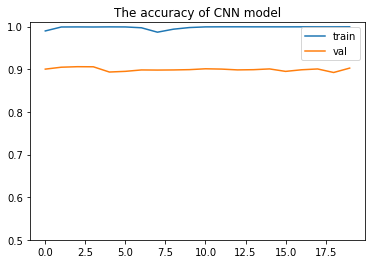

In [36]:
# 绘图
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.ylim(ymin=0.5, ymax=1.01)
plt.title("The accuracy of CNN model")
plt.legend(["train", "val"])

二分类

In [37]:
labels = np.concatenate((pos_label, neg_label), axis=0)
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42, shuffle=True)

In [38]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
conv1 = Conv1D(128, 2, activation='relu')(embedded_sequences)
conv1 = tf.keras.layers.GlobalMaxPooling1D()(conv1)
conv2 = Conv1D(128, 4, activation='relu')(embedded_sequences)
conv2 = tf.keras.layers.GlobalMaxPooling1D()(conv2)
conv3 = Conv1D(128, 5, activation='relu')(embedded_sequences)
conv3 = tf.keras.layers.GlobalMaxPooling1D()(conv3)

x = tf.keras.layers.Concatenate(axis=-1)([conv1, conv2, conv3])
# x = tf.layers.Flatten()(x)
x = Dense(128, activation='relu')(x)
x = tf.layers.Dropout(0.2)(x)
preds = Dense(1, activation='sigmoid')(x)

In [39]:
model = Model(inputs=sequence_input, outputs=preds)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 300)      13597200    input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 19, 128)      76928       embedding[2][0]                  
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 17, 128)      153728      embedding[2][0]                  
__________________________________________________________________________________________________
conv1d_8 (

In [40]:
y_val[:2]

array([0., 1.])

In [41]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [42]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=20, batch_size=128)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 28s 706us/step - loss: 0.3127 - acc: 0.8707 - val_loss: 0.2494 - val_acc: 0.9035
Epoch 2/20
40000/40000 [==============================] - 27s 663us/step - loss: 0.1957 - acc: 0.9270 - val_loss: 0.2379 - val_acc: 0.9085
Epoch 3/20
40000/40000 [==============================] - 26s 647us/step - loss: 0.1373 - acc: 0.9510 - val_loss: 0.2521 - val_acc: 0.9034
Epoch 4/20
40000/40000 [==============================] - 31s 773us/step - loss: 0.0741 - acc: 0.9748 - val_loss: 0.3051 - val_acc: 0.9013
Epoch 5/20
40000/40000 [==============================] - 30s 738us/step - loss: 0.0362 - acc: 0.9889 - val_loss: 0.3514 - val_acc: 0.9019
Epoch 6/20
40000/40000 [==============================] - 28s 701us/step - loss: 0.0276 - acc: 0.9915 - val_loss: 0.4175 - val_acc: 0.8984
Epoch 7/20
40000/40000 [==============================] - 28s 699us/step - loss: 0.0318 - acc: 0.9891 - val_loss: 0.

In [43]:
tf.keras.utils.plot_model(model=model, to_file='model_shape_out1.png', show_shapes=True)

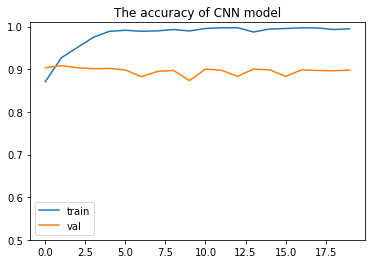

In [44]:
# 绘图
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.ylim(ymin=0.5, ymax=1.01)
plt.title("The accuracy of CNN model")
plt.legend(["train", "val"])

In [45]:
# Save entire model to a HDF5 file
MODEL_FILE = 'textcnn.h5'
model.save(MODEL_FILE)

# Recreate the exact same model, including weights and optimizer.
model = tf.keras.models.load_model(MODEL_FILE)

In [46]:
prediction = model.predict(x_val[:4])

In [47]:
prediction

array([[6.524366e-11],
       [9.999976e-01],
       [9.999199e-01],
       [9.999999e-01]], dtype=float32)

In [69]:
predictLabel = (prediction > 0.5) + 0
predictLabel.reshape((predictLabel.shape[0]))

array([0, 1, 1, 1])

In [51]:
x_val[:4]

array([[  575,    61,   158,    37,    50,    16,    11,    25,     4,
            1,   424,    93,    11,   137,     4,    40,    97,    93,
            6,   144],
       [   48,   236,   732,   126,     1,    72,    10,    14,     3,
          257,    11,    52,     3,    72,   224,    21,    12,    41,
           88,    90],
       [  530,     2,    31,    14,     1,    76,    10,   135,     1,
          513,   683,   120,    67, 13642,  4870,     3,     3,    83,
          142,  1288],
       [    3,    63,   618,     2,   392,   199,     1,    66,   538,
            2,     1,   242,   337,    14,     3,    96,  1442,    20,
         7415,     5]], dtype=int32)

In [53]:
index_word = dict(zip(word_index.values(), word_index.keys()))

In [72]:
for i,indexList in enumerate(x_val[:4]):
    wordList = [index_word.get(index) for index in indexList]
    print("text:%s, predict --> %s" % (wordList, predictLabel[i][0]))

text:['别人', '吃', '吗', '？', '小', '就', '不', '说', '了', '，', '可是', '真的', '不', '新鲜', '了', '这', '一次', '真的', '很', '失望'], predict --> 0
text:['价格', '虽然', '不算', '便宜', '，', '但是', '也', '不错', '。', '个头', '不', '大', '。', '但是', '从', '京东', '买', '东西', '方便', '啊'], predict --> 1
text:['店家', '的', '服务', '不错', '，', '物流', '也', '很快', '，', '不用', '期待', '着', '什么', '时侯', '收获', '。', '。', '你', '值得', '拥有'], predict --> 1
text:['。', '我们', '定', '的', '大床', '房', '，', '挺', '安静', '的', '，', '总体', '来说', '不错', '。', '前台', '结账', '没有', '银联', '！'], predict --> 1
